## Creating and classifying the CNN network of genshin impact characters 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import random
import os
import matplotlib.pyplot as plt


In [2]:
all_models = models.list_models()
print(all_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

In [3]:
import random
from PIL import Image
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

train_transofrm = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.TrivialAugmentWide(num_magnitude_bins=15),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

In [4]:
data_path = Path("data/")
image_path = data_path / "GI"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

# Loading data using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transofrm)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)



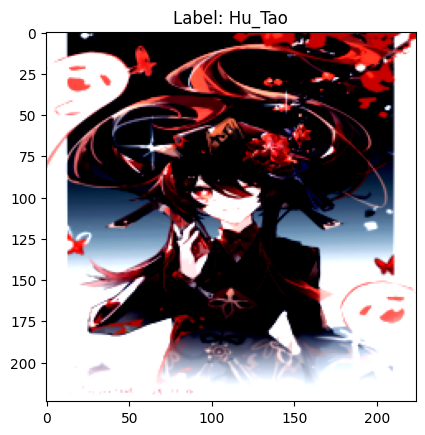

In [15]:
# Checking out the data

randindex = random.randint(0, len(train_dataset))
img, label = train_dataset[randindex][0], train_dataset[randindex][1]

class_names = train_dataset.classes
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.show()

In [5]:
dict_params = {
  "num_classes": 4,
}
GI_model = models.densenet121(progress=True, **dict_params)

print(GI_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
# put a random image through the model
first_batch = next(iter(train_dataloader))
output = GI_model(first_batch[0])
print(output.shape)

torch.Size([32, 4])


In [14]:
# Set the hyperparameters

LEARNING_RATE = 0.001
EPOCHS = 15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOSS_FN = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(GI_model.parameters(), lr=LEARNING_RATE)
device = "cuda" if torch.cuda.is_available() else "cpu"



In [12]:
#defining the training loop

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [13]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
train_results = train(GI_model, train_dataloader, test_dataloader, OPTIMIZER, LOSS_FN, 5)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 20%|██        | 1/5 [09:25<37:41, 565.49s/it]

Epoch: 1 | train_loss: 0.6626 | train_acc: 0.7673 | test_loss: 0.8680 | test_acc: 0.7188


 40%|████      | 2/5 [18:16<27:14, 545.00s/it]

Epoch: 2 | train_loss: 0.6433 | train_acc: 0.7819 | test_loss: 1.0080 | test_acc: 0.7740


 60%|██████    | 3/5 [29:28<20:06, 603.05s/it]

Epoch: 3 | train_loss: 0.5823 | train_acc: 0.7812 | test_loss: 0.6354 | test_acc: 0.8077


 80%|████████  | 4/5 [44:11<11:53, 713.56s/it]

Epoch: 4 | train_loss: 0.5577 | train_acc: 0.8092 | test_loss: 0.2675 | test_acc: 0.9279


100%|██████████| 5/5 [58:53<00:00, 706.66s/it]

Epoch: 5 | train_loss: 0.5396 | train_acc: 0.7959 | test_loss: 0.2692 | test_acc: 0.9303


In [23]:
def plot_loss_acc_curves(results: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(results["train_loss"], label="train_loss")
    ax[0].plot(results["test_loss"], label="test_loss")
    ax[0].set_title("Loss")
    ax[0].legend()
    
    ax[1].plot(results["train_acc"], label="train_acc")
    ax[1].plot(results["test_acc"], label="test_acc")
    ax[1].set_title("Accuracy")
    ax[1].legend()
    
    plt.show()

    

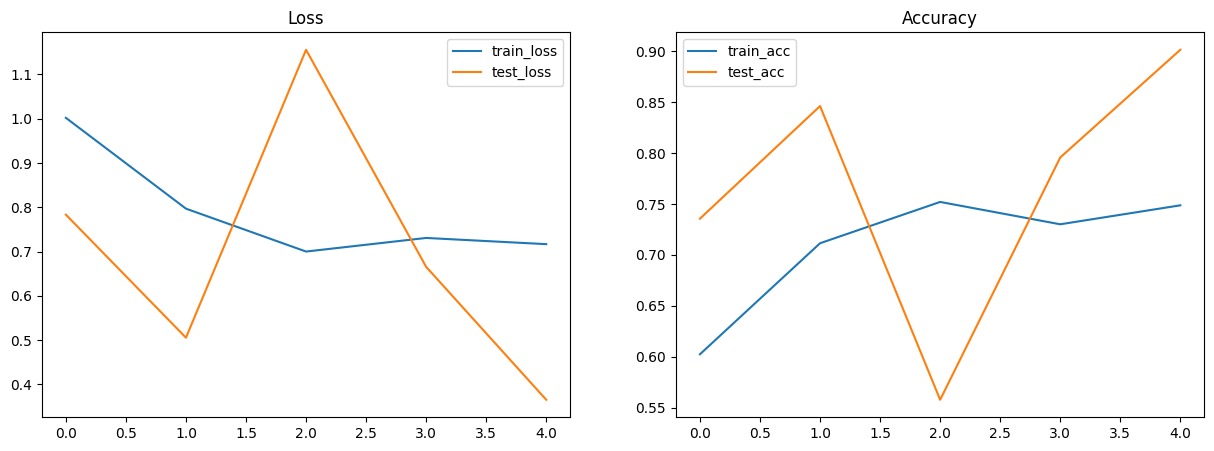

In [51]:
plot_loss_acc_curves(train_results)

In [24]:
# Plot predictions
import random
import matplotlib.pyplot as plt

def plot_predictions(model: torch.nn.Module, 
                    dataloader: torch.utils.data.DataLoader,
                    class_names: list,
                    x: int = 2,
                    y: int = 2):
    model.eval()

    images = []
    true_labels = []

    for i in range(x * y):
        randindex = random.randint(0, len(dataloader.dataset)-1)
        img, label = dataloader.dataset[randindex]
        images.append(img)
        true_labels.append(label)

    with torch.inference_mode():
        images = torch.stack(images).to(device)
        pred_logits = model(images)
        pred_labels = pred_logits.argmax(dim=1)

    fig, ax = plt.subplots(x, y, figsize=(20, 20))

    for i in range(x):
        for j in range(y):
            index = i * y + j
            ax[i, j].imshow(images[index].permute(1, 2, 0).cpu())
            ax[i, j].set_title(f"Tr: {class_names[true_labels[index]]} P: {class_names[pred_labels[index]]}", color=("green" if true_labels[index] == pred_labels[index] else "red"))
            ax[i, j].axis("off")

    plt.show()



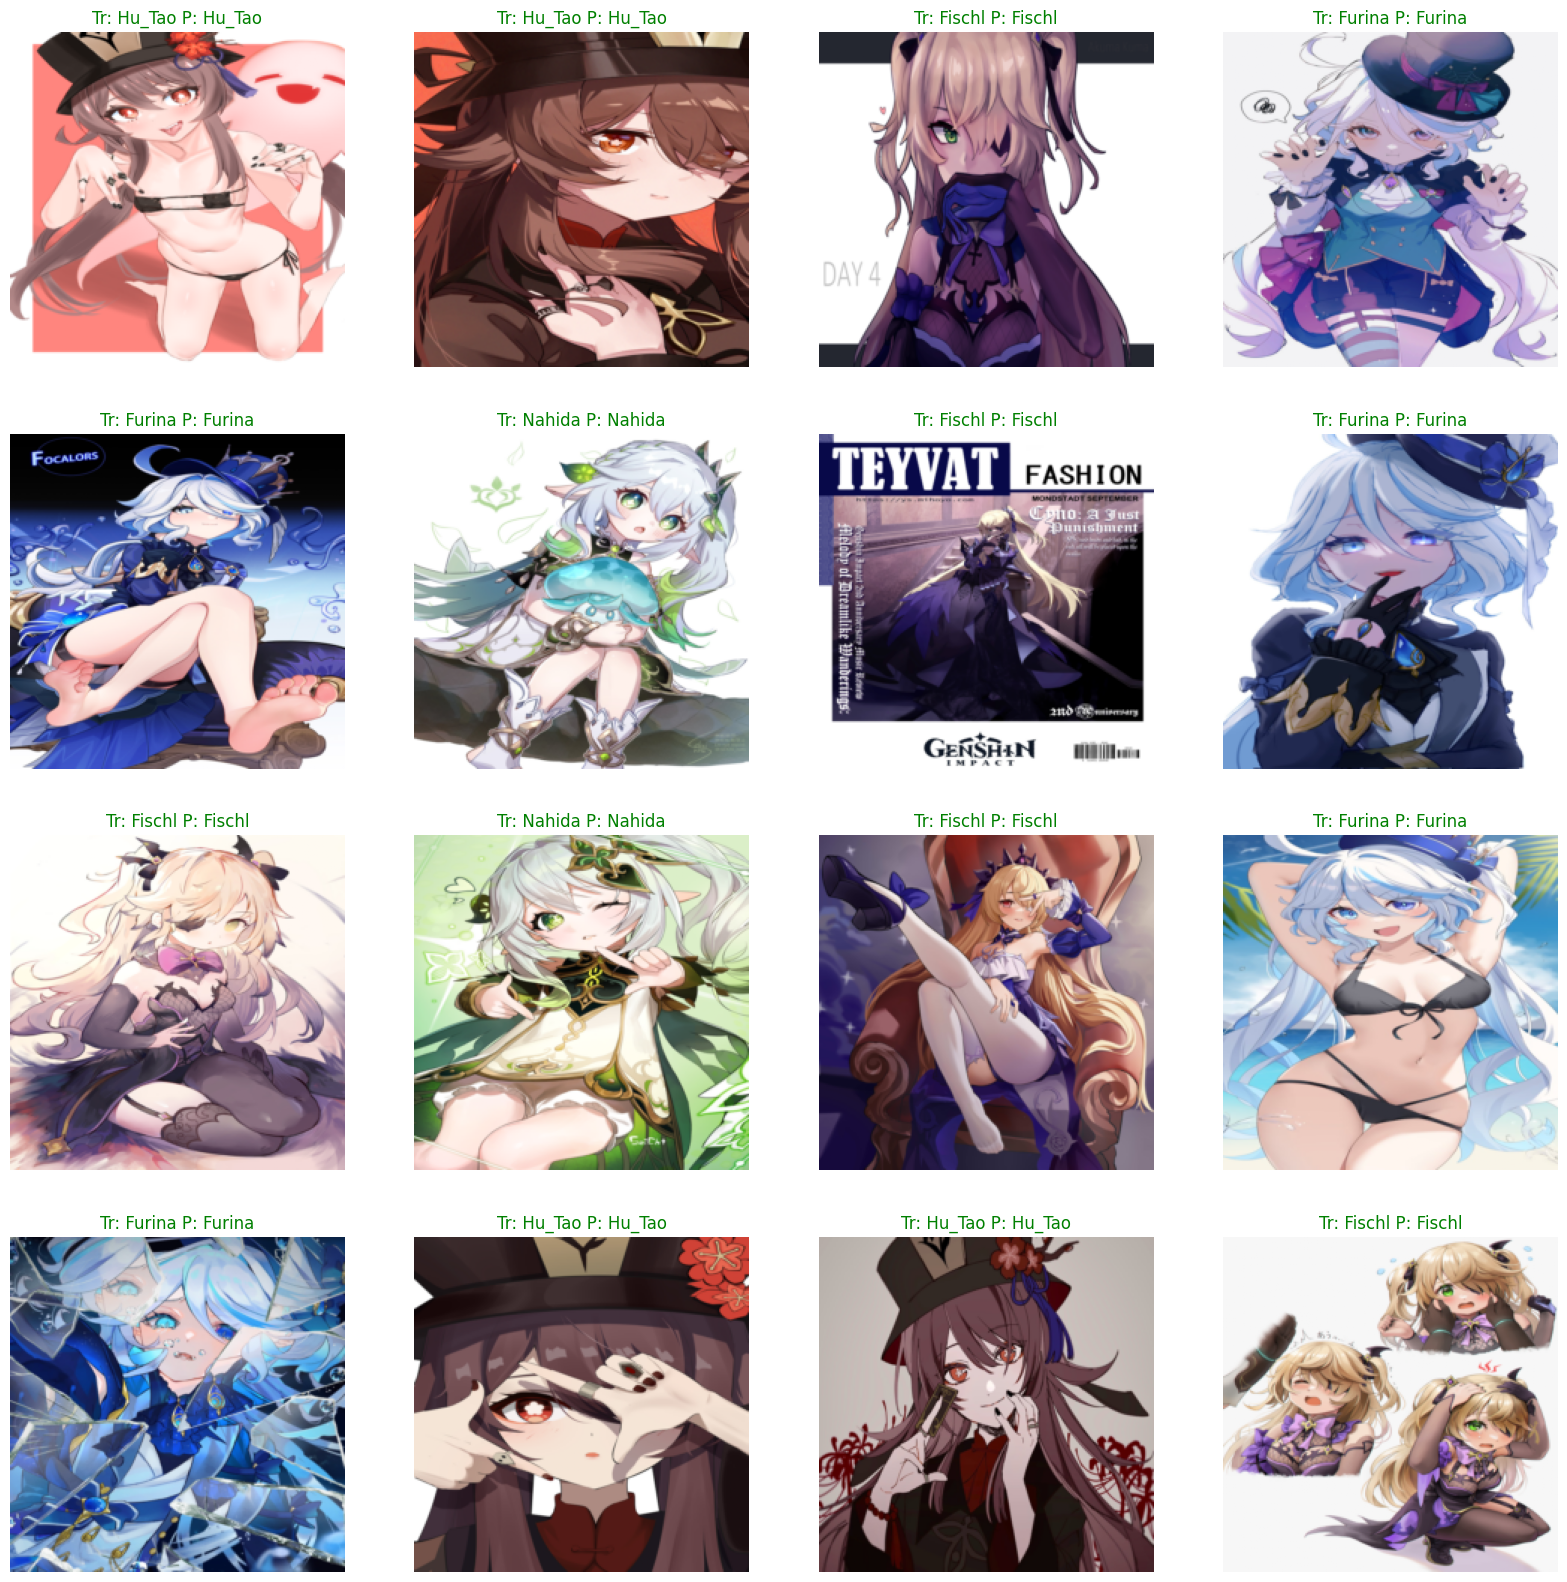

In [36]:
plot_predictions(GI_model, test_dataloader, class_names, 4, 4)

In [25]:
# a function to load an image from path and make a prediction, displaying the original image and the predicted class as title, green if correct, red if incorrect

def predict_image(model: torch.nn.Module,
                  img_path: str,
                  class_names: list):
    model.eval()
    img = Image.open(img_path)
    img = test_transform(img).unsqueeze(0).to(device)
    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_class = class_names[pred_label]
    img = img.cpu().squeeze(0).permute(1, 2, 0)
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis("off")
    plt.show()


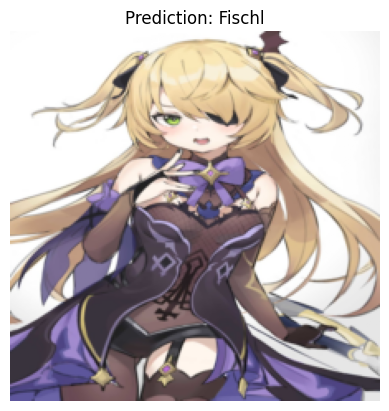

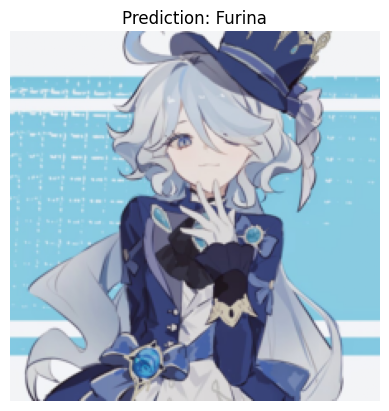

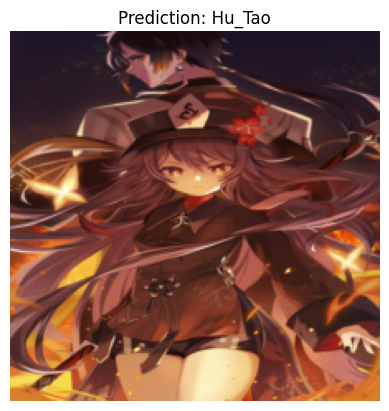

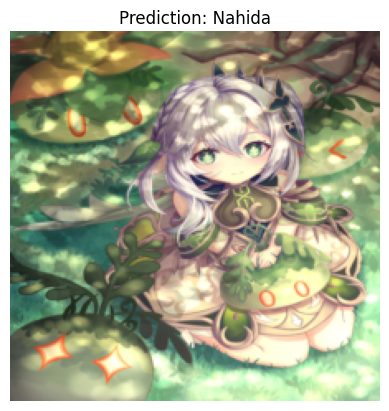

In [26]:
fischl = image_path / "fischl.jpg"
furina = image_path / "furina.jpg"
hu_tao = image_path / "hu_tao.jpg"
nahida = image_path / "nahida.jpg"

predict_image(GI_model, fischl, class_names)
predict_image(GI_model, furina, class_names)
predict_image(GI_model, hu_tao, class_names)
predict_image(GI_model, nahida, class_names)

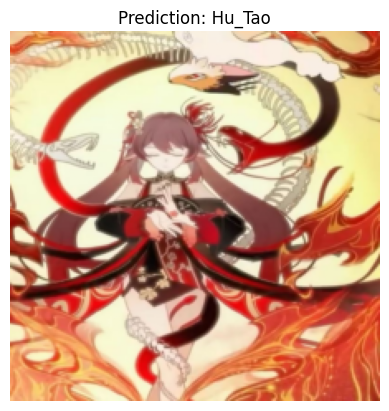

In [27]:
nahi2 = image_path / "nahi2.jpg"

predict_image(GI_model, nahi2, class_names)

In [28]:
# Save the model

torch.save(GI_model.state_dict(), "GI_model_400_100.pth")


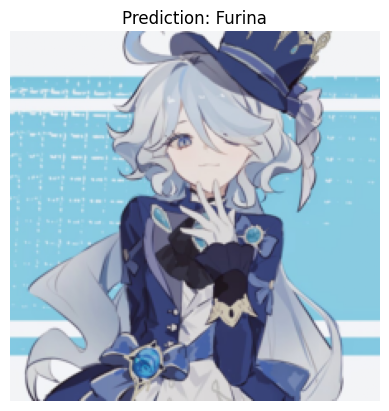

In [18]:
# Load model
import torch
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = Path("data/")
model_path = data_path / "../models/GI_model_400_100.pth"
# GI_model = models.densenet121()
GI_model.load_state_dict(torch.load(model_path))
GI_model.eval()

# Predict with loaded model
predict_image(GI_model, furina, class_names)




data\GI\train\fischl\399.jpg


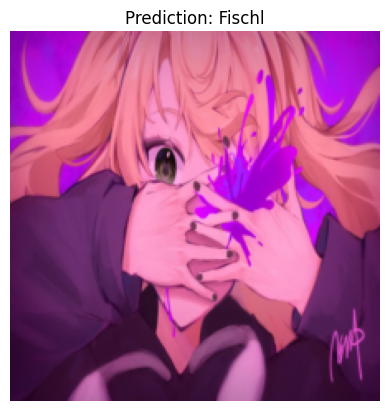

In [29]:
hu_tao_29 = image_path /"train/fischl/399.jpg"
print(hu_tao_29)
predict_image(GI_model, hu_tao_29, class_names)

In [31]:
# create a confusion matrix of the whole test set
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model: torch.nn.Module, 
                          dataloader: torch.utils.data.DataLoader, 
                          class_names: list):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred_logits = model(X)
            pred_labels = pred_logits.argmax(dim=1)
            
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))

    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    #print the total accuracy
    print(f"Total accuracy: {np.trace(cm)/np.sum(cm)}")
    


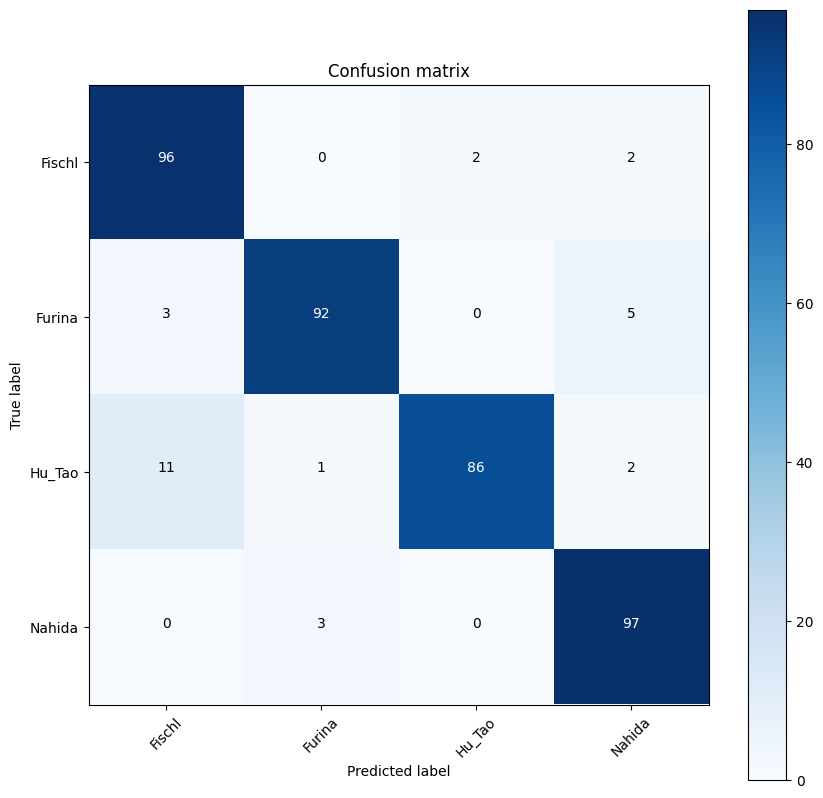

Total accuracy: 0.9275


In [32]:
plot_confusion_matrix(GI_model, test_dataloader, class_names)

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


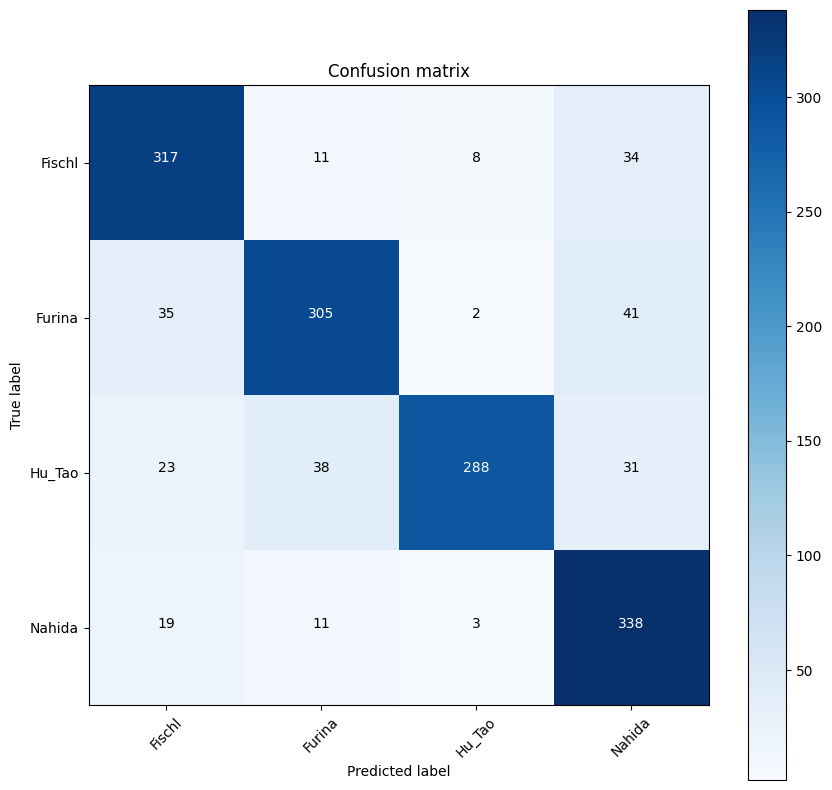

Total accuracy: 0.8297872340425532


In [33]:
plot_confusion_matrix(GI_model, train_dataloader, class_names)